# 2. Figures

Before running this notebook, follow instructions in 1-preprocess.ipynb to preprocess and prepare data for plotting.

## Imports

In [1]:
!pip install --no-cache --quiet regionmask

In [2]:
from string import ascii_lowercase

import cartopy.crs as ccrs
import dask
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import xarray

import libs.metrics
import libs.plot
import libs.utils
import libs.stats

matplotlib.rcParams.update({ 'font.size': 16 })

## Data + metrics

In [3]:
ds_obs = xarray.open_mfdataset(
    paths='data/obs_processed_2003_2018.nc'
)

ds_clim = xarray.open_mfdataset(
    paths='data/era5_surface_processed_2003_2018.nc'
)
ds_clim_mean = ds_clim\
    .mean('month')\
    .compute()

In [4]:
metrics = [
    {
        'key': 'h_obs',
        'domain': 'global',
        'f': libs.metrics.h_obs,
        'type': 'mixed',
        'title': '$H^{obs}$'
    },
    {
        'key': 'h_w25',
        'domain': 'global',
        'f': libs.metrics.h_w25,
        'type': 'mixed',
        'title': '$H^{W25}$'
    }, {
        'key': 'h_a25',
        'domain': 'global',
        'f': libs.metrics.h_a25,
        'type': 'microbial',
        'title': '$H^{A25}$'
    }, {
        'key': 'h_s08',
        'domain': 'global',
        'f': libs.metrics.h_s08,
        'type': 'microbial',
        'title': '$H^{S08}$'
    }, {
        'key': 'h_s16',
        'domain': 'global',
        'f': libs.metrics.h_s16,
        'type': 'complex',
        'title': '$H^{S16}$'
    }, {
        'key': 'h_if',
        'domain': 'marine',
        'f': libs.metrics.h_icefree,
        'type': 'microbial',
        'title': '$H^{IF}$'
    }, {
        'key': 'h_dg19h',
        'domain': 'terrestrial',
        'f': libs.metrics.h_dg19h,
        'type': 'microbial',
        'title': '$H^{DG19H}$'
    }, {
        'key': 'h_dg19na',
        'domain': 'terrestrial',
        'f': libs.metrics.h_dg19na,
        'type': 'microbial',
        'title': '$H^{DG19NA}$'
    } 
]

In [5]:
# Calculate habitability for each metric + observed
for i, metric in enumerate(metrics):
    key = metric['key']

    data_input = ds_obs if key == 'h_obs' else ds_clim_mean
    ds_clim_mean[key] = metric['f'](data_input)

    # Apply masks to terrestrial/marine domains
    if metric['domain'] == 'terrestrial':
        ds_clim_mean[key] = libs.utils.mask_to_land(ds_clim_mean[key])
    elif metric['domain'] == 'marine':
        ds_clim_mean[key] = libs.utils.mask_to_ocean(ds_clim_mean[key])

## Main

### Figure 1

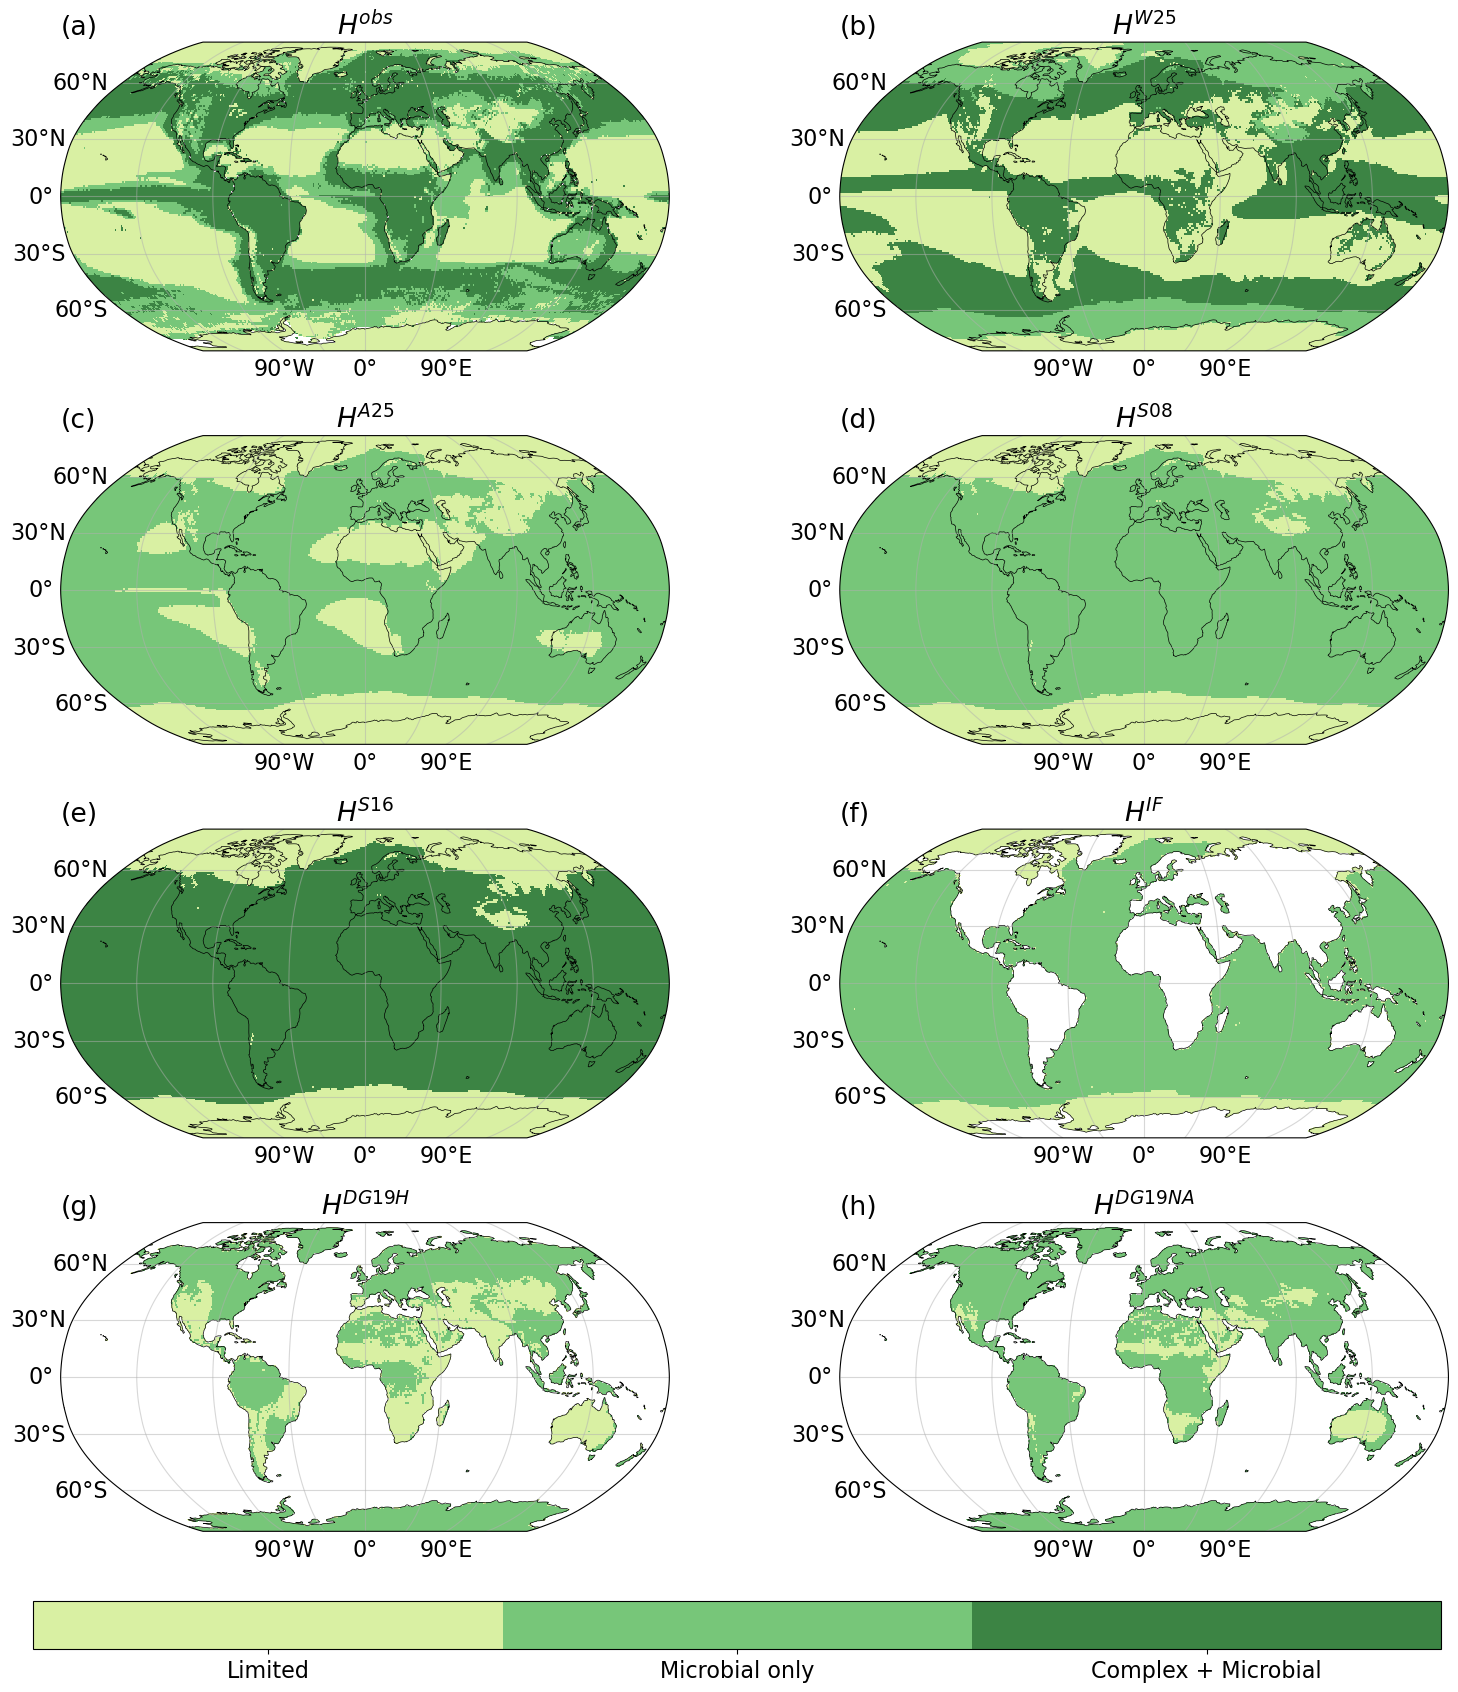

In [6]:
fig, axs = libs.plot.create_fig(
    shape=(4, 2),
    h=4,
    w=8,
)

subfigs = []
subfig_labels = list(ascii_lowercase)

i = 0
for metric in metrics:
    ax = axs[i]
    key = metric['key']

    subfigs.append(
        ds_clim_mean[key].plot(
            add_colorbar=False,
            ax=ax,
            transform=ccrs.PlateCarree(),
            **libs.metrics.get_metric_kwargs()['plot_kwargs']
        )
    )
    
    ax.set_title(metric['title'])
    ax.coastlines(resolution='110m', linewidth=0.5)
    libs.plot.draw_gridlines(ax)

    # text_x = 0.04 if i % 2 == 0 else 0.53
    # text_y = 0.971 - (np.floor(i / 2) * 0.246)
    # fig.text(text_x, text_y, f'({subfig_labels[i]})')
    ax.set_title(f'({subfig_labels[i]})', loc='left')
    
    i += 1

fig.tight_layout()

cax = fig.colorbar(
    subfigs[0],
    cax=fig.add_axes([0.06, -0.04, 0.88, 0.03]),
    location='bottom',
    **libs.metrics.get_metric_kwargs()['colorbar_kwargs']
)

cax.set_ticks(libs.metrics.get_metric_kwargs()['colorbar_ticks'])
cax.set_ticklabels(libs.metrics.get_metric_kwargs()['colorbar_ticklabels'])

fig.savefig(
    'figs/fig1-earth-hab.png',
    transparent=True,
    bbox_inches='tight',
    pad_inches=0.01
);

### Figure A1

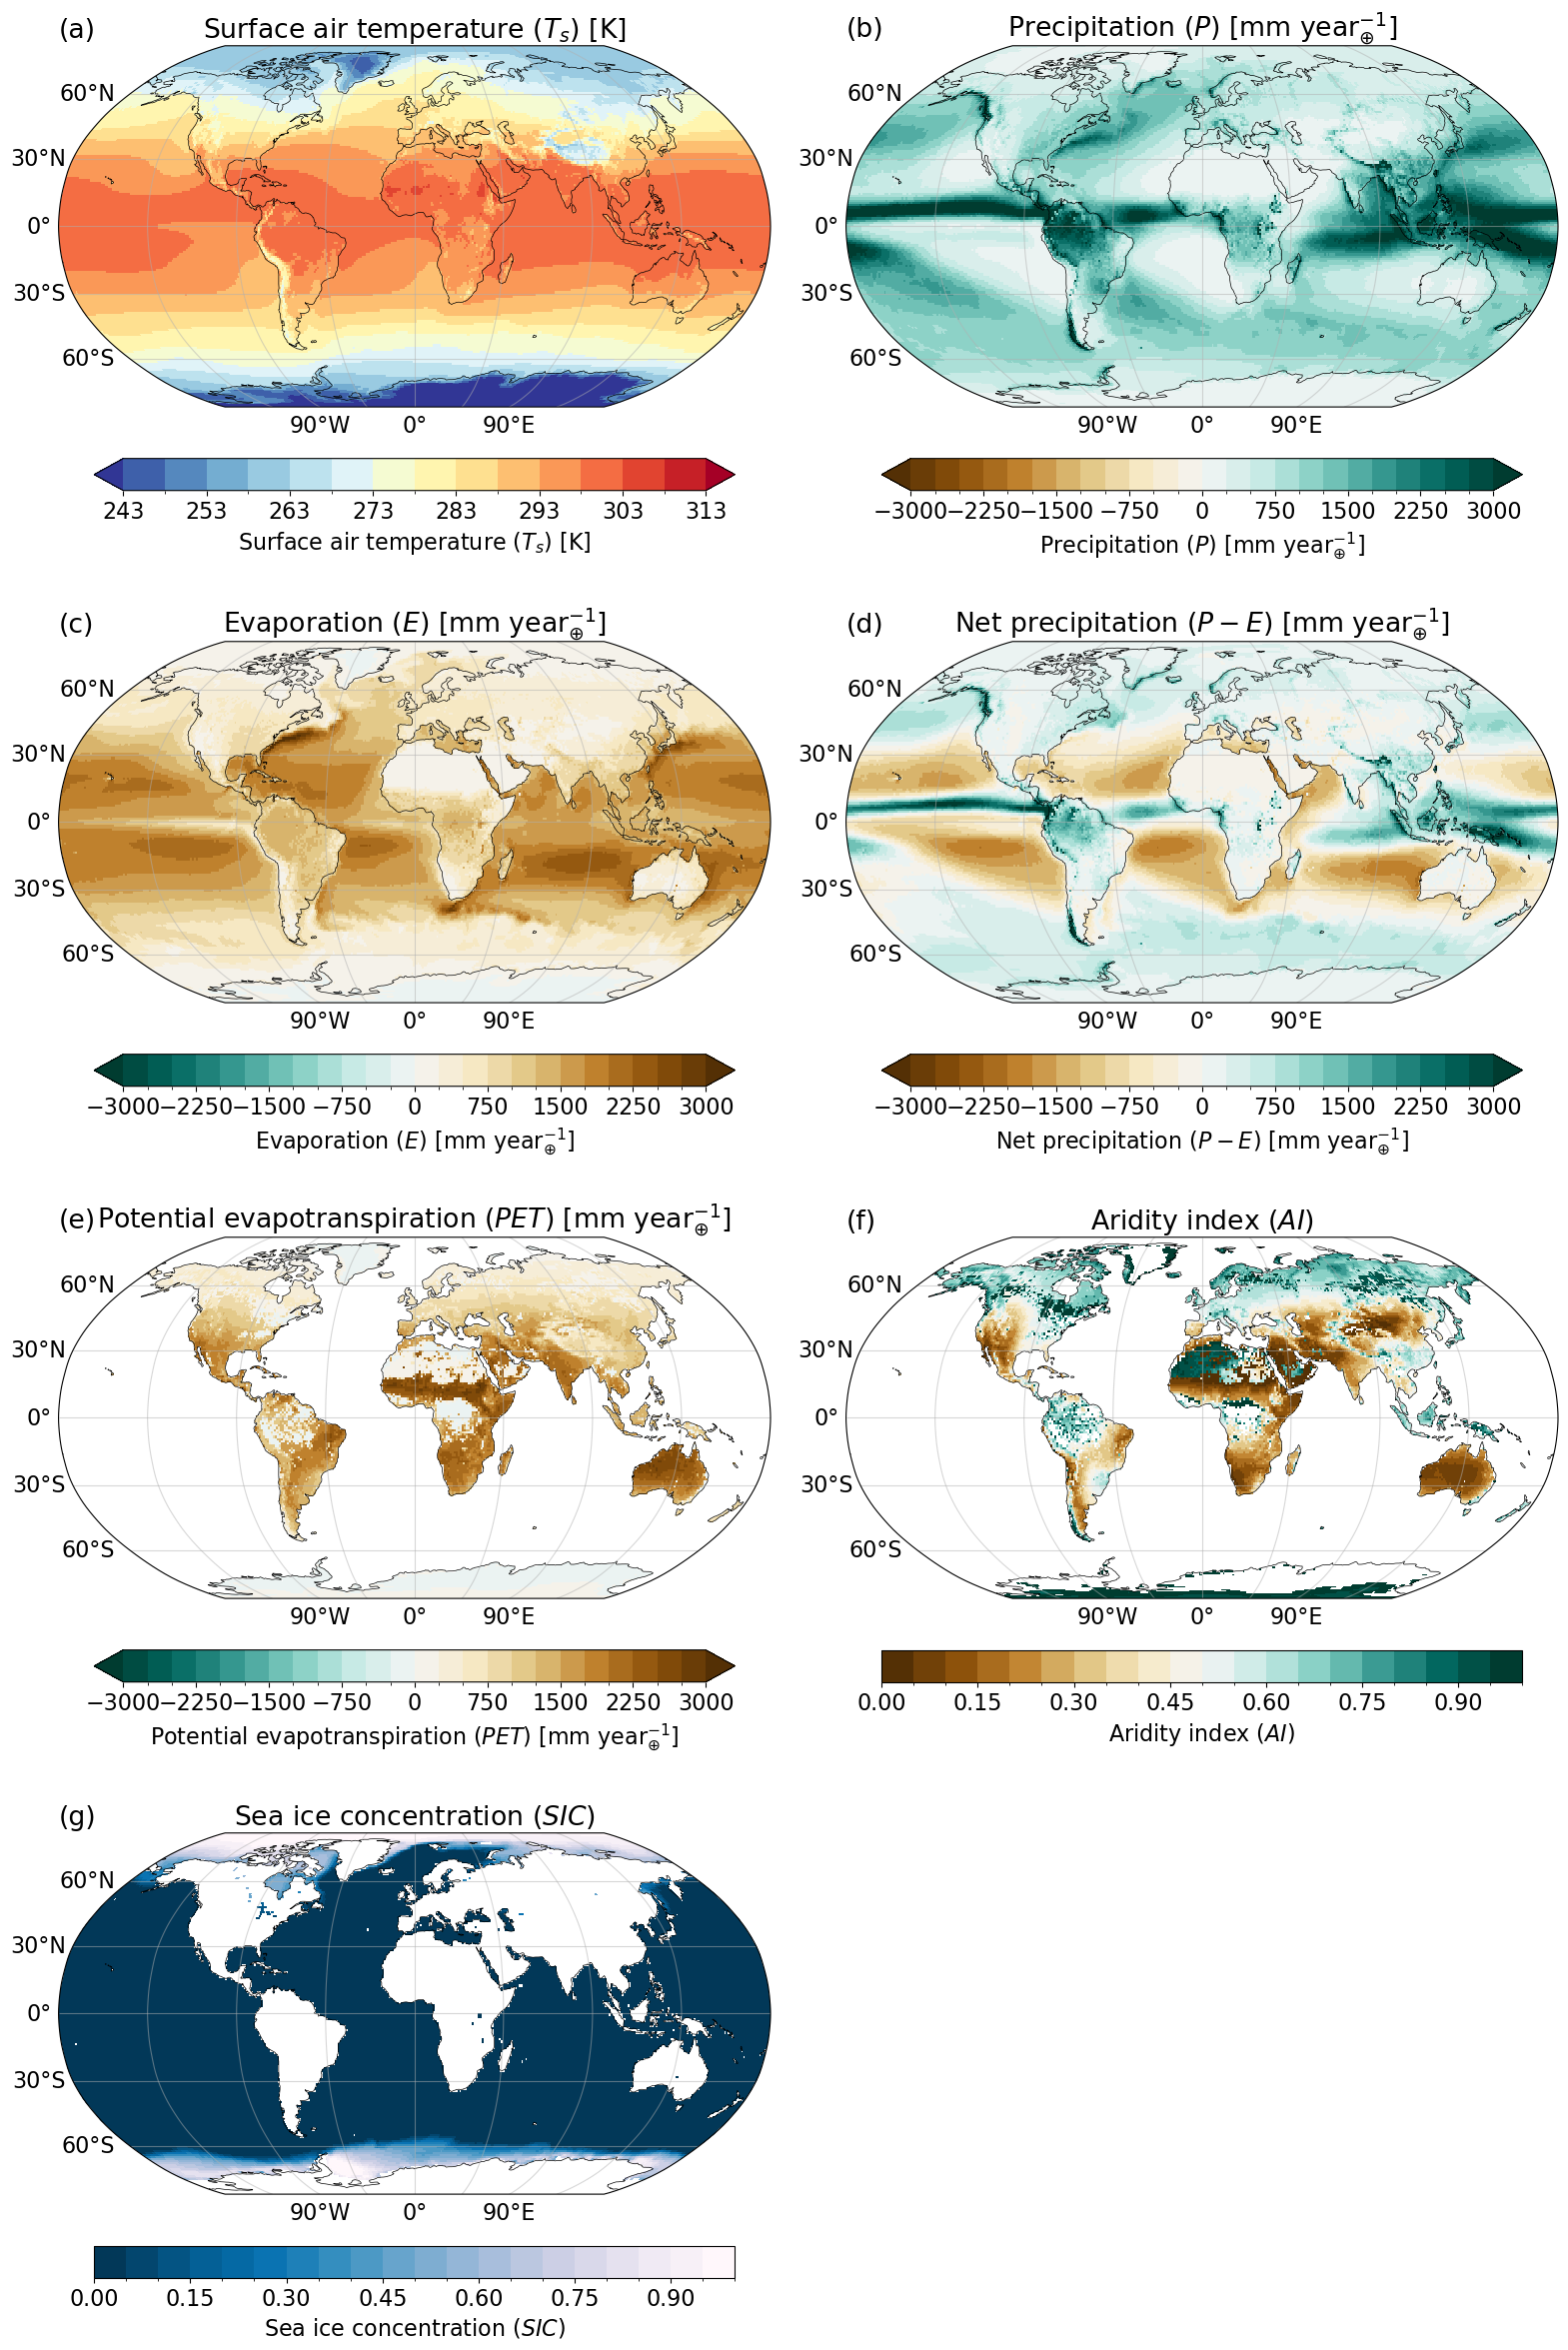

In [7]:
fig, axs = libs.plot.create_fig(
    shape=(4, 2),
    h=6, 
    w=8,
)
fig.delaxes(axs[7])

subfigs = []
subfig_labels = list(ascii_lowercase)

conf_vars = [
    {
        'key': lambda x: x['tas'],
        'title': 'Surface air temperature ($T_s$) [K]',
        'plot_kwargs': {
            'cmap': 'RdYlBu_r',
            'extend': 'both',
            'levels': np.arange(243, 318, 5)
        }
    },
    {
        'key': lambda x: x['pr'] * 86400.0 * 365,
        'title': 'Precipitation ($P$) [mm year$_{\oplus}^{-1}$]',
        'plot_kwargs': {
            'cmap': 'BrBG',
            'extend': 'both',
            # 'levels': np.arange(-10, 11, 1) * 365
            'levels': np.arange(-3000, 3250, 250)
        }
    },
    {
        'key': lambda x: x['evspsbl'] * 86400.0 * 365,
        'title': 'Evaporation ($E$) [mm year$_{\oplus}^{-1}$]',
        'plot_kwargs': {
            'cmap': 'BrBG_r',
            'extend': 'both',
            # 'levels': np.arange(-10, 11, 1) * 365
            'levels': np.arange(-3000, 3250, 250)
        }
    },
    {
        'key': lambda x: (x['pr'] - x['evspsbl']) * 86400.0 * 365,
        'title': 'Net precipitation ($P - E$) [mm year$_{\oplus}^{-1}$]',
        'plot_kwargs': {
            'cmap': 'BrBG',
            'extend': 'both',
            # 'levels': np.arange(-10, 11, 1) * 365
            'levels': np.arange(-3000, 3250, 250)
        }
    },
    {
        'key': lambda x: x['pet'] * 86400.0 * 365,
        'title': 'Potential evapotranspiration ($PET$) [mm year$_{\oplus}^{-1}$]',
        'plot_kwargs': {
            'cmap': 'BrBG_r',
            'extend': 'both',
            # 'levels': np.arange(-10, 11, 1) * 365
            'levels': np.arange(-3000, 3250, 250)
        }
    },
    {
        'key': lambda x: x['ai'],
        'title': 'Aridity index ($AI$)',
        'plot_kwargs': {
            'cmap': 'BrBG',
            'extend': 'neither',
            'levels': np.arange(0, 1.05, 0.05)
        }
    },
    {
        'key': lambda x: x['siconc'],
        'title': 'Sea ice concentration ($SIC$)',
        'plot_kwargs': {
            'cmap': 'PuBu_r',
            'extend': 'neither',
            'levels': np.arange(0, 1.05, 0.05)
        }
    }
]

i = 0
for conf in conf_vars:
    ax = axs[i]

    if 'f' in conf:
        subfigs.append(
            conf['f'](
                ds_clim_mean,
                {
                    'add_colorbar': False,
                    'ax': ax,
                    'levels': np.arange(0, 10, 0.5),
                    'transform': ccrs.PlateCarree(),
                    'x': 'lon',
                    'y': 'lat'
                }
            )
        )
    else:
        conf_data = conf['key'](ds_clim_mean)
        subfigs.append(
            conf_data.plot(
                add_colorbar=False,
                ax=ax,
                transform=ccrs.PlateCarree(),
                **conf['plot_kwargs']
            )
        )

    cax = fig.colorbar(
        subfigs[i],
        ax=ax,
        label=conf['title'],
        location='bottom',
        pad=0.1,
        shrink=0.9
    )
    
    ax.set_title(conf['title'])
    ax.coastlines(resolution='110m', linewidth=0.5)
    libs.plot.draw_gridlines(ax)

    ax.set_title(f'({subfig_labels[i]})', loc='left')
    
    i += 1

fig.tight_layout()

fig.savefig(
    'figs/supfig1-earth-clim.png',
    transparent=True,
    bbox_inches='tight',
    pad_inches=0
);

## Statistics & fractional habitability

In [8]:
domains = [
    { 'title': 'global', 'filter': lambda data: data, 'dict': {} },
    { 'title': 'marine', 'filter': libs.utils.mask_to_ocean, 'dict': {} },
    { 'title': 'terrestrial', 'filter': libs.utils.mask_to_land, 'dict': {} },
]
cats = ['microbial', 'complex']

obs_data = ds_clim_mean['h_obs']

for domain in domains:
    for metric in metrics:
        key = metric['key']
        pred_data = ds_clim_mean[key]
        pred_data_filtered = domain['filter'](pred_data)
        h_frac = libs.metrics.calc_hab_fractions(pred_data_filtered)

        # format: [PC_m, HSS_m, CHI^2_m, fH_m, PC_c, HSS_c, CHI^2_c, fH_c]
        dict_item = []
        
        for type in cats:
            h_frac_type = f'{h_frac[type]:.2f}'
            # format: [PC, HSS, CHI^2, fH]
            dict_item_part = [None, None, None, None]
        
            if key == 'h_obs':
                dict_item_part[3] = h_frac_type
                dict_item += dict_item_part
                
                continue

            if (metric['domain'] != 'global') and (metric['domain'] != domain['title']):
                dict_item += dict_item_part

                continue

            if (metric['type'] != 'mixed') and (metric['type'] != type):
                dict_item += dict_item_part

                continue
    
            ctable, f_skill_score = libs.stats.get_ctable(
                obs_data,
                pred_data_filtered,
                type=type
            )
            ss = f_skill_score(ctable)        
            try:
                chi2 = scipy.stats.chi2_contingency(ctable)
                # format: [PC_m, HSS_m, X_m, f_m, PC_c, HSS_c, X_c, f_c]
                chi2_text = f'{chi2.statistic:.0f}'
                if round(chi2.pvalue, 4) > 0:
                    chi2_text += f' (p={chi2.pvalue:.4f}'
                if chi2.dof > 1:
                    chi2_text += f' (dof={chi2.dof})'

                dict_item_part = [
                    f'{ss["pc"]:.2f}',
                    f'{ss["hss"]:.2f}',
                    chi2_text,
                    h_frac_type
                ]

            except:
                dict_item_part = [
                    f'{ss["pc"]:.2f}',
                    f'{ss["hss"]:.2f}',
                    None,
                    h_frac_type
                ]

            dict_item += dict_item_part

        # Only append if actual data to show
        if dict_item != [None, None, None, None, None, None, None, None]:
            domain['dict'][metric['title']] = dict_item

    df_hab = pd.DataFrame.from_dict(domain['dict']).transpose()
    df_hab.columns = pd.MultiIndex.from_tuples([
        ('Microbial', '$PC$'),
        ('Microbial', '$HSS$'),
        ('Microbial', '$\chi^2$'),
        ('Microbial', '$f_H$'),
        ('Complex', '$PC$'),
        ('Complex','$HSS$'),
        ('Complex','$\chi^2$'),
        ('Complex','$f_H$'),
    ])

    df_hab = df_hab.fillna('-')

    df_hab = df_hab.style.set_table_styles(
        [
            dict(selector='th, td', props=[('text-align', 'center')]),
            dict(selector='th:first-child', props=[('text-align', 'left')])
        ]
    )

    print('Domain: ' + domain['title'])
    display(df_hab)
    print('-' * 100)


Domain: global


----------------------------------------------------------------------------------------------------
Domain: marine


----------------------------------------------------------------------------------------------------
Domain: terrestrial


----------------------------------------------------------------------------------------------------
